# 08_SpatialPCA

R kernel

See README.md file for SpatialPCA install instructions

Following tutorial: https://lulushang.org/SpatialPCA_Tutorial/DLPFC.html
- raw data converted to R: https://drive.google.com/drive/folders/1ve4MqQU9zswmFEWArx_YILhMfjn0oeK5

In [3]:
output_dir <- "data/08"
dir.create(output_dir)

Warning message in dir.create(output_dir):
“'data/08' already exists”


In [4]:
library(SpatialPCA)
library(ggplot2)
library(Seurat)
library(SingleCellExperiment)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    

In [7]:
sample_names=c("151507", "151508", "151509", "151510", "151669", "151670", "151671" ,"151672","151673", "151674" ,"151675" ,"151676")
clusterNum=c(7,7,7,7,5,5,5,5,7,7,7,7) # each sample has different ground truth cluster number
load("/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC_RData_Shang/151507.RData") 
print(dim(count_sub)) # The count matrix
print(dim(xy_coords)) # The x and y coordinates. We flipped the y axis for visualization.


[1] 33538  4226
[1] 4226    2


In [61]:
for (i in seq_along(sample_names)) {
    print(sample_names[i])
    print(clusterNum[i])
}

[1] "151507"
[1] 7
[1] "151508"
[1] 7
[1] "151509"
[1] 7
[1] "151510"
[1] 7
[1] "151669"
[1] 5
[1] "151670"
[1] 5
[1] "151671"
[1] 5
[1] "151672"
[1] 5
[1] "151673"
[1] 7
[1] "151674"
[1] 7
[1] "151675"
[1] 7
[1] "151676"
[1] 7


In [5]:
xy_coords = as.matrix(xy_coords)
rownames(xy_coords) = colnames(count_sub) # the rownames of location should match with the colnames of count matrix
LIBD = CreateSpatialPCAObject(
    counts=count_sub, location=xy_coords, project = "SpatialPCA",
    gene.type="spatial",
    sparkversion="spark",
    numCores_spark=5, 
    gene.number=3000, customGenelist=NULL,
    min.loctions = 20, min.features=20
)


## Use SCTransform function in Seurat to normalize data. 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 14262 by 4226

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4226 cells



  |======================================================================| 100%


Found 64 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 14262 genes



  |======================================================================| 100%


Computing corrected count matrix for 14262 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 51.97523 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  4226 
## number of total features:  3974 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 


Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  1288  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  1288  significant spatially variable genes. 


In [6]:
LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)
LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum=20) 
LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)

## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0387320509362326  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] "Eigen decomposition on kernel matrix!"
[1] "Using all eigenvectors and eigenvalues in the Kernel matrix!"


In [8]:
LIBD_fn <- paste(output_dir, file="151507_Spatial_PCA.LIBD_obj.RData",sep = "/")
LIBD_fn

[1] "data/08/151507_Spatial_PCA.LIBD_obj.RData"

In [11]:
saveRDS(LIBD, file=LIBD_fn)

In [8]:
clusterlabel= walktrap_clustering(clusternum=clusterNum[1],latent_dat=LIBD@SpatialPCs,knearest=70 ) 
# here for all 12 samples in LIBD, we set the same k nearest number in walktrap_clustering to be 70. 
# for other Visium or ST data, the user can also set k nearest number as round(sqrt(dim(SpatialPCAobject@SpatialPCs)[2])) by default.
clusterlabel_refine = refine_cluster_10x(clusterlabels=clusterlabel,location=LIBD@location,shape="hexagon")


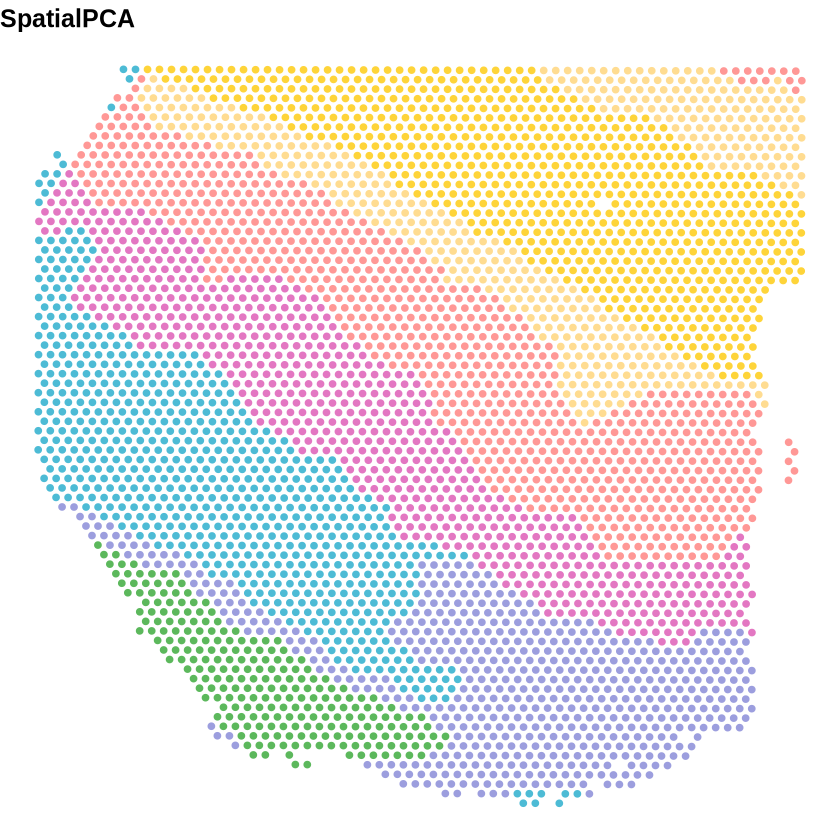

In [10]:
cbp=c("#9C9EDE" ,"#5CB85C" ,"#E377C2", "#4DBBD5" ,"#FED439" ,"#FF9896", "#FFDC91")
plot_cluster(location=xy_coords,clusterlabel=clusterlabel_refine,pointsize=1.5,title_in=paste0("SpatialPCA"),color_in=cbp)

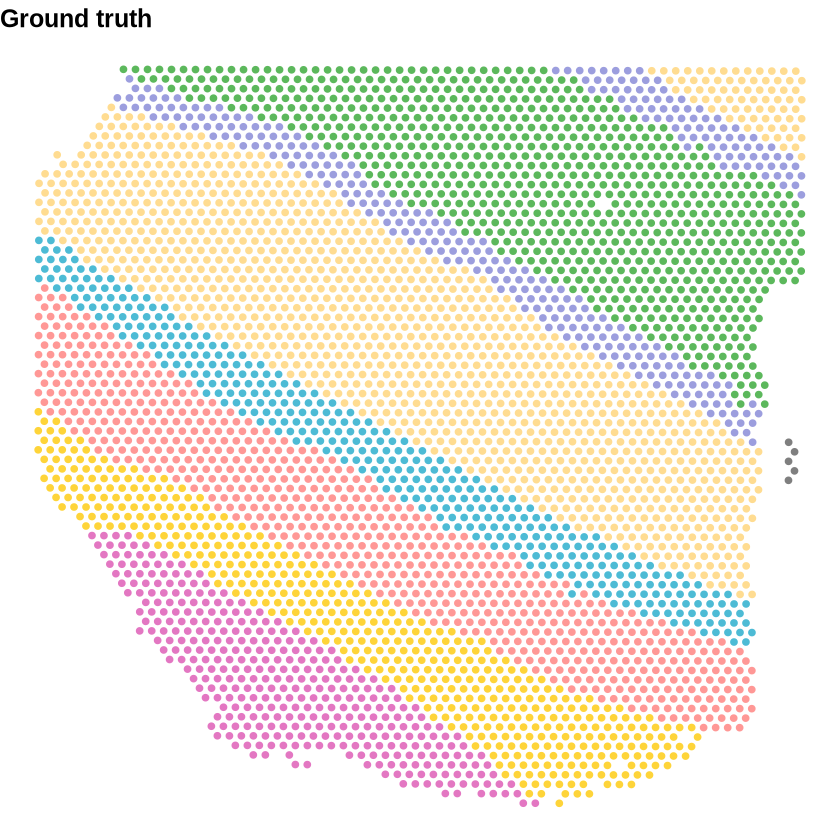

In [11]:
truth = KRM_manual_layers_sub$layer_guess_reordered[match(colnames(LIBD@normalized_expr),colnames(count_sub))]
cbp=c("#5CB85C" ,"#9C9EDE" ,"#FFDC91", "#4DBBD5" ,"#FF9896" ,"#FED439", "#E377C2", "#FED439")
plot_cluster(location=xy_coords,truth,pointsize=1.5,title_in=paste0("Ground truth"),color_in=cbp)

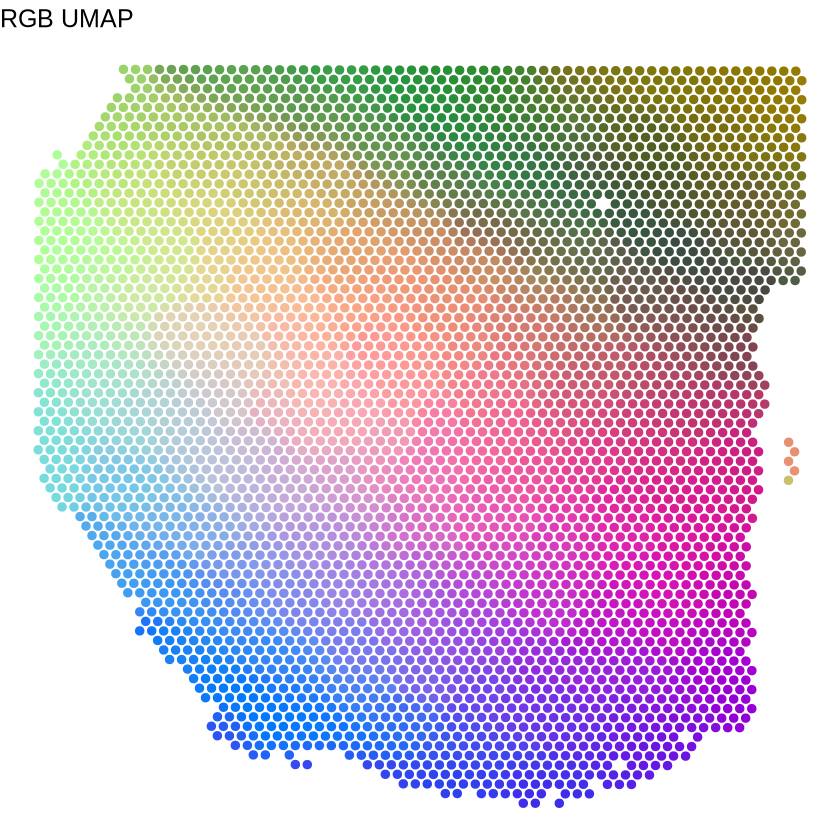

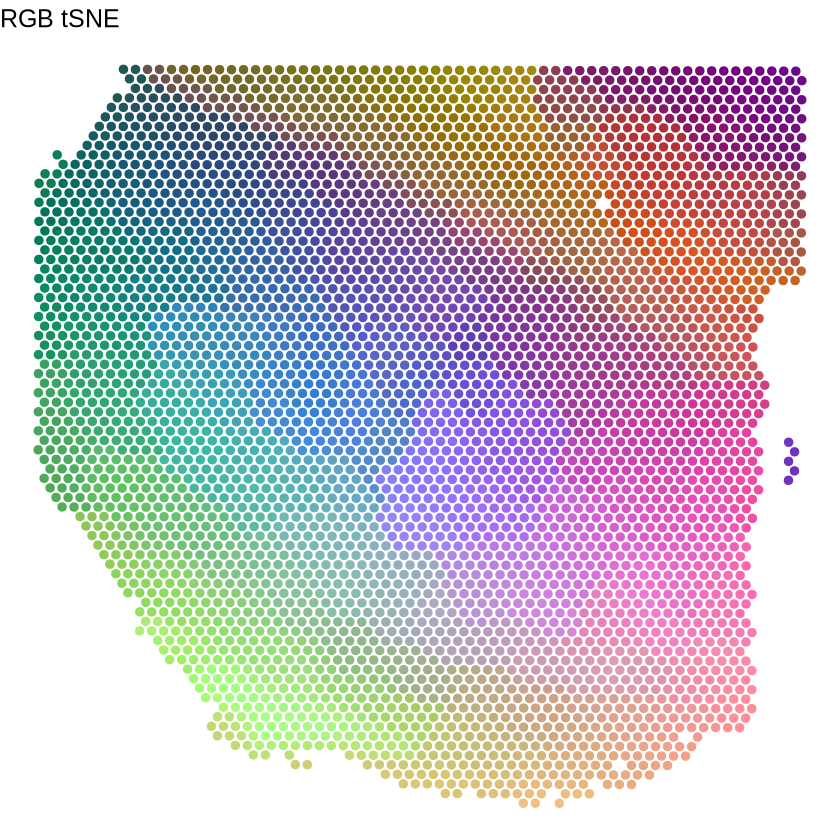

In [12]:
set.seed(1234)
p_UMAP = plot_RGB_UMAP(LIBD@location,LIBD@SpatialPCs,pointsize=2,textsize=15)
p_UMAP$figure

p_tSNE = plot_RGB_tSNE(LIBD@location,LIBD@SpatialPCs,pointsize=2,textsize=15)
p_tSNE$figure

Convert to anndata

In [40]:
library(Matrix)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




In [23]:
read_LIBD <- readRDS(LIBD_fn)

In [25]:
spatialpcs_fn

[1] "data/08/151507_Spatial_PCA.spatialPCs.tsv"

In [27]:
spatialpcs_fn <- paste(output_dir, file="151507_Spatial_PCA.spatialPCs.tsv",sep = "/")
write.table(read_LIBD@SpatialPCs, spatialpcs_fn, sep="\t")

In [31]:
counts_mtx <- paste(output_dir, file="151507_Spatial_PCA.counts.mtx",sep = "/")
Matrix::writeMM(read_LIBD@counts, file=counts_mtx)

NULL

In [34]:
counts_features_fn <- paste(output_dir, file="151507_Spatial_PCA.counts_features.tsv",sep = "/")
writeLines(rownames(read_LIBD@counts), counts_features_fn)

In [35]:
counts_barcodes_fn <- paste(output_dir, file="151507_Spatial_PCA.counts_barcodes.tsv",sep = "/")
writeLines(colnames(read_LIBD@counts), counts_barcodes_fn)

In [38]:
class(read_LIBD@normalized_expr)

[1] "matrix" "array"

In [41]:
sparse_normalized_expr <- Matrix(read_LIBD@normalized_expr, sparse=TRUE)

normalized_expr_mtx <- paste(output_dir, file="151507_Spatial_PCA.normalized_expr.mtx",sep = "/")
Matrix::writeMM(sparse_normalized_expr, file=normalized_expr_mtx)

NULL